# Overview

There are a couple of metrics/plots introduced:
 - Task latency: time delay between tasks
 - GPU Device Utilization: Overall time utilized per device (as well as CPU cores)
 - Parallel efficiency: framework scalability 
 - real-time utilization/overhead: memory, network, system load, I/O

The main goal of introducing new plots/metrics is to capture the followings:
 - RCT framework capability as a middleware
 - Scaling performance along with an application
 - usage of other resource components

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
latency_raw_example="""print sum, count, ave, median, min, max: 2.32356	154	0.0150881	0.0114332	0.000786066	0.10901
print sum, count, ave, median, min, max: 4.80094	308	0.0155875	0.0105334	0	0.146309
print sum, count, ave, median, min, max: 9.63283	636	0.015146	0.011211	0.000102758	0.262024
print sum, count, ave, median, min, max: 26.5798	1274	0.0208633	0.0127307	0	1.54501
print sum, count, ave, median, min, max: 43	2498	0.0172138	0.0149311	0	0.397132
print sum, count, ave, median, min, max: 141.917	5133	0.027648	0.024538	0.000102282	0.570579
print sum, count, ave, median, min, max: 409.44	9402	0.0435482	0.0401268	0	0.77939"""

In [8]:
latency=[ x.split(":")[1].lstrip().split() for x in latency_raw_example.split("\n")]
latency_df = pd.DataFrame(latency, columns=['sum', 'count', 'avg', 'median', 'min', 'max'])
latency_df = latency_df.apply(pd.to_numeric) # convert all columns of DataFrame
latency_df['avg_milli'] = latency_df['avg'] * 1000

## Task Latency

Task latency is a point-to-point measurement about task placement to show time delays between tasks and reveal time variance for concurrent tasks at scale.

$$Task latency = StartTime_{Task_i} - StartTime_{Task_j}$$

### Sample plot with average latency
average latency = sum(Task latency * CPU cores)/(Total number of CPU cores), where 1 CPU core is assigned 1 task 

/home/hrlee/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


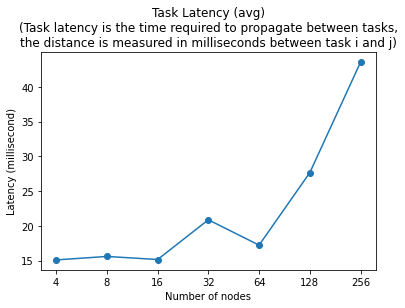

In [14]:
ax = latency_df[['avg_milli']].plot(marker='o', legend=False)
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Latency (millisecond)')
ax.set_title('Task Latency (avg)\n(Task latency is the time required to propagate between tasks,\nthe distance is measured in milliseconds between task i and j)')
ax.set_xticklabels([0,4,8,16,32,64,128,256])
plt.show()

### Sample approach measuring Latency towards Stages and Pipelines

Text(0.5, 1.0, 'pipeline latency')

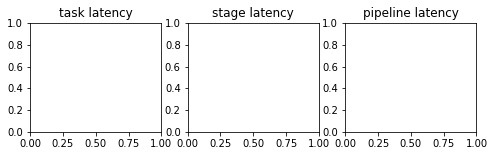

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(8,2))
axes[0].set_title('task latency')
axes[1].set_title('stage latency')
axes[2].set_title('pipeline latency')

## GPU Utilization using heatmap

This metric is to show the following items:
 - the balance of resource distribution over time where the optimal case shows an even distribution across GPUs at high utilization rate (white color map = 100% utilization, black color map = 0%)
 
This can be used for a debugging purpose to identify problematic, underperformed nodes/cores. It is also open to possible plots mapped to EnTK task (task count per core instead of utilization %) showing task distribution corresponding to GPU indexes.

### Sample plot for DeepDriveMD case, utilizing 20 Nodes on Summit (6 GPUs per node)

Text(0.5, 1.0, 'GPUs Utilization\n(Each box =  the amount of time in a certain period allocated to GPU / workflow life time)')

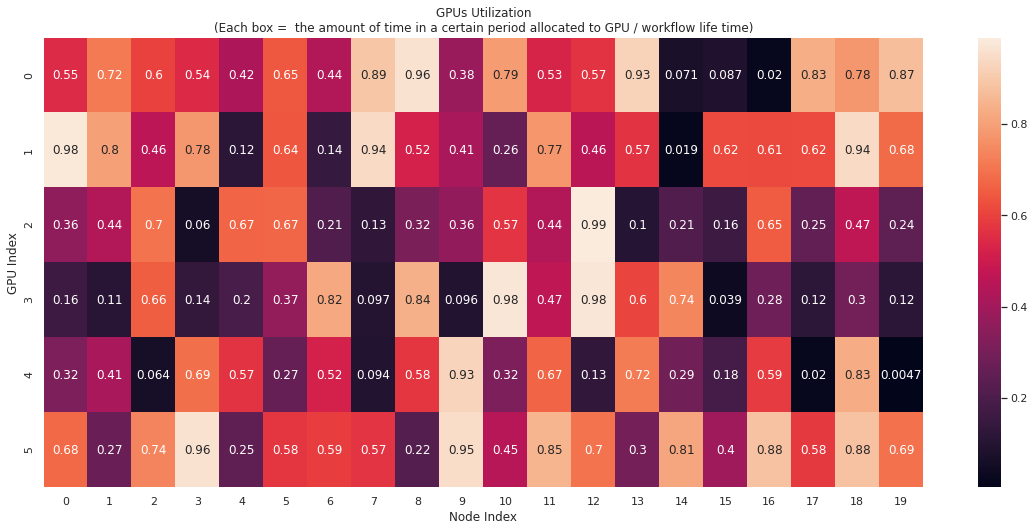

In [108]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
uniform_data = np.random.rand(6, 20)
sns.set(rc={'figure.figsize':(19.7,8.27)})
ax = sns.heatmap(uniform_data,annot=True)
ax.set_xlabel('Node Index')
ax.set_ylabel('GPU Index')
ax.set_title('GPUs Utilization\n(Each box =  the amount of time in a certain period allocated to GPU / workflow life time)')

### Sample plot for 1024 Nodes 
- Using Node groups, e.g. the first group includes node 1 to node 32
- and removing GPU device representation on y-axis

Text(0.5, 1.0, 'GPUs Utilization')

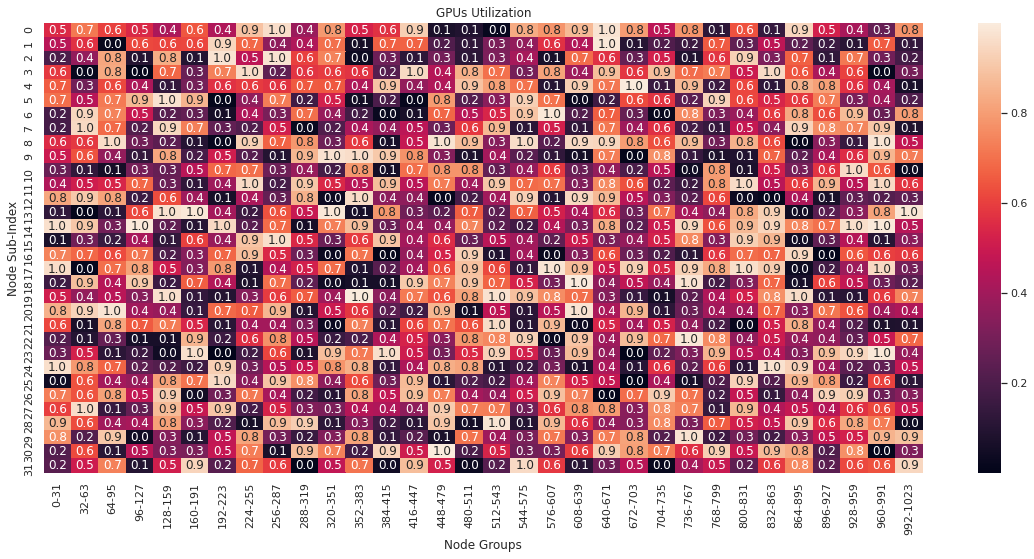

In [94]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
uniform_data = np.random.rand(32, 32)
# sns.set(rc={'figure.figsize':(19.7,8.27)})
ax = sns.heatmap(uniform_data,annot=True,fmt='.1f')
ax.set_xticklabels([ "{}-{}".format((x-1)*32, x*32-1) for x in range(1,33)], rotation=90)
ax.set_xlabel('Node Groups')
ax.set_ylabel('Node Sub-Index')
ax.set_title('GPUs Utilization')
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0, .2, .75, 1])
#cbar.set_ticklabels(['low', '20%', '75%', '100%'])

### Sample plot for CPUs

- Y-axis represents physical CPU Cores, instead of GPU devices

Text(0.5, 1.0, 'CPUs Utilization\n(Each box = CPU duration / workflow life time)')

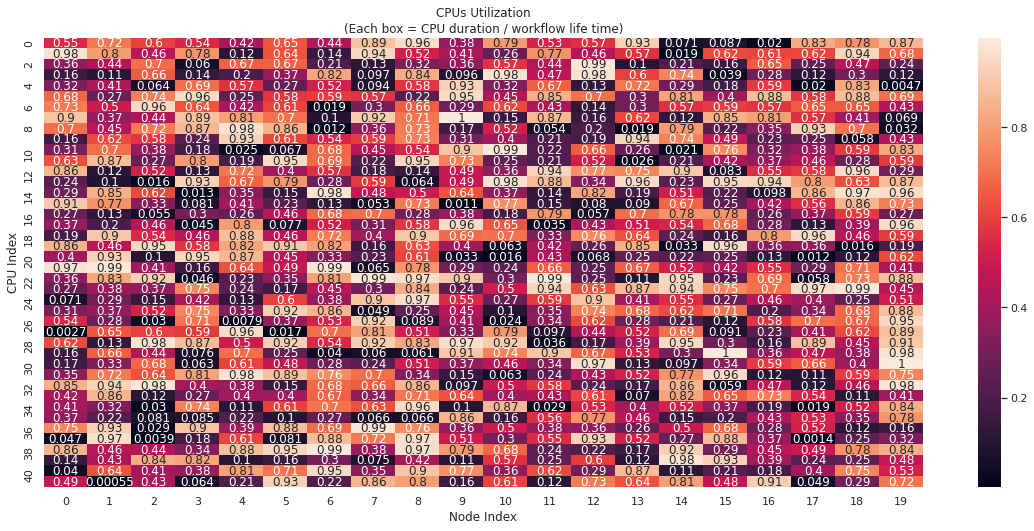

In [95]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
uniform_data = np.random.rand(42, 20)
sns.set(rc={'figure.figsize':(19.7,8.27)})
ax = sns.heatmap(uniform_data,annot=True)
ax.set_xlabel('Node Index')
ax.set_ylabel('CPU Index')
ax.set_title('CPUs Utilization\n(Each box = CPU duration / workflow life time)')
#cbar = ax.collections[0].colorbar
#cbar.set_ticks([0, .2, .75, 1])
#cbar.set_ticklabels(['low', '20%', '75%', '100%'])

### Utilization combining GPU and CPU usage

This additional plot is introduced to show that:
 - how CPU and GPU both are utilized
 - a scheduler's capability for balancing resource distribuion
 - resource assignment mapping to a task
 
### Sample plot
- shares Y-axis for node indexes (left side is for GPUs and right side is for CPU cores)
- two bars are available:
   -  avg: sum(number of cpu/gpus per task)/(number of tasks) on a given host
   -  max: max(number of cpu/gpus concurrently used)

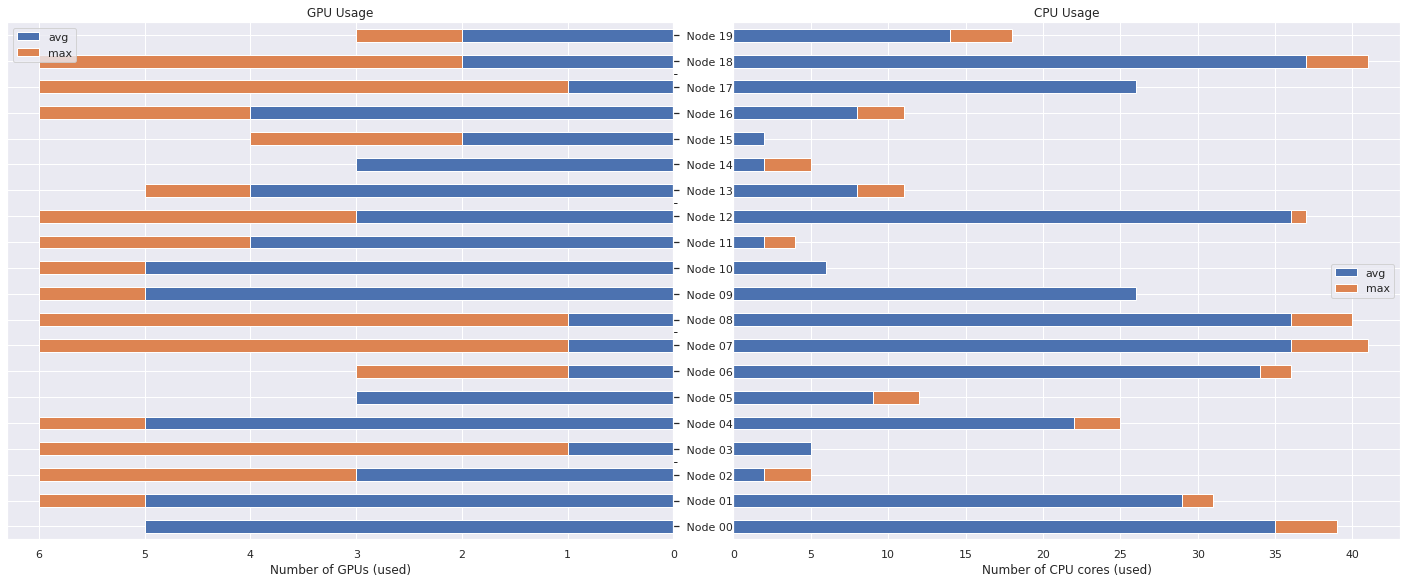

In [227]:

y = range(20)
x1 = np.random.randint(low=1, high=6, size=(20,))
x2 = np.random.randint(low=1, high=42, size=(20,))
newx2=[]
for x in x2:
    newx2.append([x, min(42, x + np.random.randint(6))-x])
df_cpu= pd.DataFrame(newx2, columns=['avg', 'max'])
newx1=[]
for x in x1:
    newx1.append([x, min(6, x + np.random.randint(6))-x])
df_gpu= pd.DataFrame(newx1, columns=['avg', 'max'])


fig, axes = plt.subplots(ncols=2, sharey=True)
#axes[0].barh(y, x1, align='center', color='gray', zorder=10)
df_gpu.plot.barh(stacked=True, align='center',  ax=axes[0])
axes[0].set(title='GPU Usage')
#axes[1].barh(y, x2, align='center', color='gray', zorder=10)
df_cpu.plot.barh(stacked=True, align='center',  ax=axes[1])
axes[1].set(title='CPU Usage')

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=[" Node {:02d} ".format(x) for x in range(20)])
axes[0].yaxis.tick_right()
#axes[1].yaxis.tick_left()
axes[0].set_xlabel('Number of GPUs (used)')
axes[1].set_xlabel('Number of CPU cores (used)')
for ax in axes.flat:
    ax.margins(0.05)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.09)
plt.show()

## Parallel efficiency

$$ single run TTX / Parallel run TTX $$

This is the efficiency of the application (i.e. deepdrivemd) with increasing number of Nodes (weak scaling)
The purpose of this metric is to show that the run with framework is not far below the linear (optimal) reference time (flattened line at 1). In addition, it shows the capability of the large number of task executions where bare run stops at a certain point.

In [272]:

cpus = np.random.randint(low=1, high=42, size=(20,))
ts = pd.Series(cpus, index=pd.timedelta_range(start='1 day', freq='1T', periods=20))
dfc = pd.DataFrame(cpus, index=ts.index)
gpus = np.random.randint(low=1, high=6, size=(20,))
dfg = pd.DataFrame(gpus, index=ts.index)


Text(0.5, 1.0, 'Parallel Efficiency\n(Single run TTX / Parallel run TTX)')

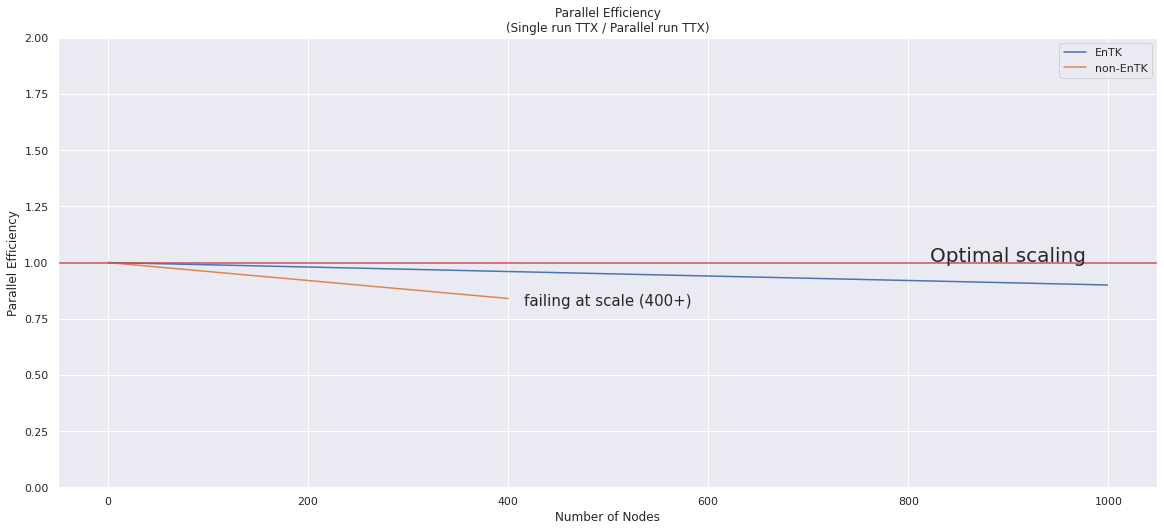

In [225]:
df = pd.DataFrame(uniform_data, columns=['EnTK','non-EnTK'])
ax = df.plot()
ax.axhline(y=1, color='r', linestyle='-')
ax.set_ylim(0,2)
ax.text(900, 1.03, 'Optimal scaling', fontsize=20, va='center', ha='center')
ax.text(500, 0.83, 'failing at scale (400+)', fontsize=15, va='center', ha='center')
ax.set_ylabel('Parallel Efficiency')
ax.set_xlabel('Number of Nodes')
ax.set_title('Parallel Efficiency\n(Single run TTX / Parallel run TTX)')